<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Modelisation_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

!pip install wikidata --quiet
!pip install datasets --quiet
!pip install spacy --quiet
!python -m spacy download en_core_web_md

import matplotlib.pyplot as plt
import pandas as pd
from wikidata.client import Client
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import spacy
import seaborn as sns
from collections import Counter
import joblib
from google.colab import files

from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data
train_df = pd.read_json('train_df_complete.json', orient="records", lines=True)
dev_df = pd.read_json('dev_df_complete.json', orient="records", lines=True)

Saving dev_df_complete.json to dev_df_complete.json
Saving train_df_complete.json to train_df_complete.json
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 50.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Loading the pretrained model
nlp = spacy.load("en_core_web_md")

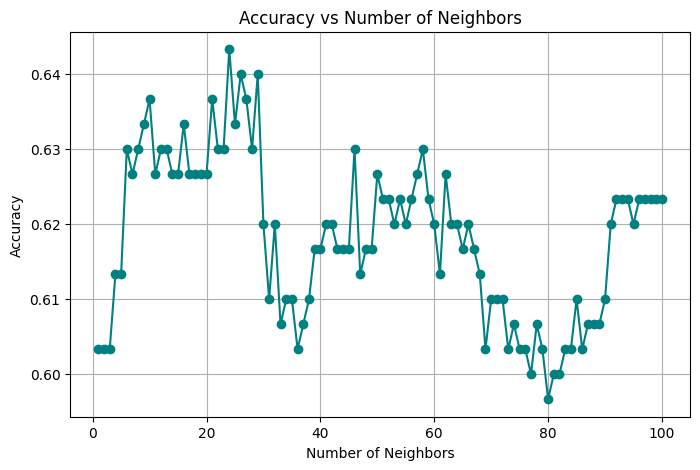

<Figure size 640x480 with 0 Axes>

In [3]:
# Exctract the texte and the label : Training
train_texts = train_df['description'].to_list()
train_labels = train_df['label_int'].to_list()

# Exctract the texte and the label : Dev
dev_texts = dev_df['description'].to_list()
dev_labels = dev_df['label_int'].to_list()

# Vectorize the texts with en_core_web_md
train_vectors = np.array([nlp(text).vector for text in train_texts])
dev_vectors = np.array([nlp(text).vector for text in dev_texts])

accuracies = {}

# We test many values of k (number of neighbors in KNN)
for k in range(1, 101):
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(train_vectors)

    predicted_labels = []

    for vec in dev_vectors:
        distances, indices = knn.kneighbors(vec.reshape(1, -1))

        # Get the k closest labels
        neighbor_labels = [train_labels[idx] for idx in indices[0]]

        # Choose the label (the most frequent one)
        label_counts = {}
        for label in neighbor_labels:
            label_counts[label] = label_counts.get(label, 0) + 1
        majority_label = max(label_counts.items(), key=lambda x: x[1])[0]

        predicted_labels.append(majority_label)

    # Compute accuracy
    accuracy = accuracy_score(dev_labels, predicted_labels)
    accuracies[k] = accuracy

# Plot Accuracy vs Number of Neighbors
plt.figure(figsize=(8, 5))
plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o', color='teal')
plt.title("Accuracy vs Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
plt.savefig('Accuracy_vs_Neighbors')

In [4]:
# We get the best k : the one that gives the best accuracy
best_k = max(accuracies, key=accuracies.get)

# We train the final model, with best_k
knn = NearestNeighbors(n_neighbors=best_k, metric='cosine')
knn.fit(train_vectors)

# We predict the labels for each item of the dev set
final_predicted_labels = []
for vec in dev_vectors:
    distances, indices = knn.kneighbors(vec.reshape(1, -1))
    neighbor_labels = [train_labels[idx] for idx in indices[0]]
    majority_label = max(set(neighbor_labels), key=neighbor_labels.count)
    final_predicted_labels.append(majority_label)

dev_df['predicted_label_KNN'] = final_predicted_labels

In [5]:
dev_df.head()

,item,name,description,type,label,subclass_depth,subclasses,instances_of,instances_of_up,date,...,category_fashion,category_comics and anime,category_music,category_films,category_biology,category_geography,category_combined,label_int,main_country_cat,predicted_label_KNN
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,cultural representative,1,0,0,3,1900,...,0,0,0,0,0,0,0,1,1,0
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,cultural exclusive,1,0,0,1,1957,...,0,0,1,0,0,0,0,0,1,0
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,cultural representative,1,0,0,2,1998,...,0,1,0,0,0,0,0,1,1,1
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,cultural exclusive,1,0,0,1,2011,...,0,0,0,1,0,0,0,0,1,1
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,cultural representative,1,0,0,1,1900,...,0,0,0,0,0,0,1,1,1,1


In [6]:
dev_df['predicted_label_KNN'].value_counts()

,count
predicted_label_KNN,
2,141
0,112
1,47


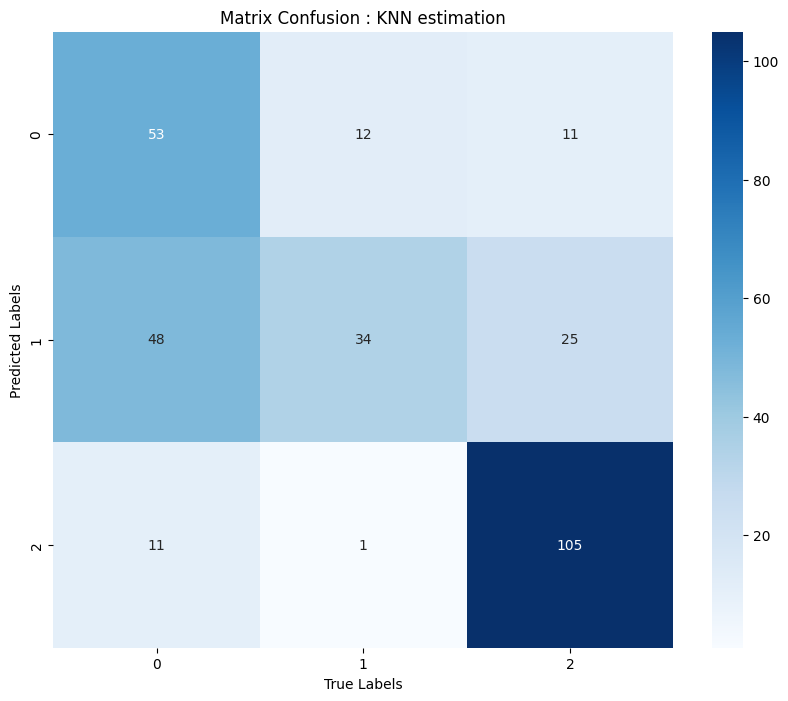

In [8]:
# Creation of the confusion matrix
y_true = dev_df['label_int']
y_pred = dev_df['predicted_label_KNN']
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matrix Confusion : KNN estimation')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [9]:
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred,average='macro')

print("Recall :", recall)
print("Precision :", precision)
print("F1-score :", f1)

Recall : 0.6375204426114411
Precision : 0.6470997973657547
F1-score : 0.6064472390548591


# Exportation

In [10]:
knn

NearestNeighbors(metric='cosine', n_neighbors=24)

In [11]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'cosine',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 24,
 'p': 2,
 'radius': 1.0}

In [12]:
# Save
joblib.dump(knn, 'model_KNN.joblib')

# Download
files.download('model_KNN.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>